## Combined Model
This notebook is the implementation on the combined data of microsoft and apple stocks. It is made in following manner:
1. Import Libraries
2. Read and process the data
    - Normalize the data
    - Polymerize data
    - Split into training and testing
    - change dimentions
3. Implement the Baseline model
    - Make model
    - Train model
    - Predict on test data
    - Calculate score and make prediction graph
3. Make Final model
    - Make and compile model 
    - Train model using Simple training
    - Predict on test data
    - Calculate score and make prediction graph
    - Train model using Framed training
    - Predict on test data
    - Calculate score and make prediction graph

## Import all libs


In [1]:
# get all the imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import tensorflow as tf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.
/Users/batman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Read Both the file and process the data

change the directory is needed

In [2]:
cd Data

/Users/batman/Documents/stock


#### Read the csv file in respective dataframe

In [3]:
# read the files
apple=pd.read_csv('AppleFinalData.csv')
micro=pd.read_csv('MicrosoftFinalData.csv')

#### Preprocess data for both the compnies seperately

In [4]:
# process the colums of the file
apple=apple.rename(columns={'Adj Close':'Price'})   # reaname the column
apple=apple.drop('Close',axis=1)                    # remove the unused column
apple['Month']=int                                  # add a blank month column in the data field

# add the data into the month column, it will take time
for i in range(len(apple)):
  apple['Month'][i]=int(apple['Date'][i].split('-')[1])

# arrange the final sequence of column
apple=apple[['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos','Month','Date','Price']]   
apple.columns   # check the finla output

/Users/batman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos', 'Month', 'Date',
       'Price'],
      dtype='object')

In [5]:
# process the colums of the file
micro=micro.rename(columns={'Adj Close':'Price'})   # reaname the column
micro=micro.drop('Close',axis=1)                    # remove the unused column
micro['Month']=int                                  # add a blank month column in the data field

# add the data into the month column, it will take time
for i in range(len(micro)):
  micro['Month'][i]=int(micro['Date'][i].split('-')[1])

# arrange the final sequence of column
micro=micro[['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos','Month','Date','Price']]   
micro.columns   # check the finla output

/Users/batman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos', 'Month', 'Date',
       'Price'],
      dtype='object')

#### Seperate the News and Stock data

In this we are only using the Opening prices of the stock fromt the Stock data into the feature set.

In [6]:
m_stock=micro.iloc[:,:1].values
m_news=micro.iloc[0:,3:7].values

In [7]:
a_stock=apple.iloc[:,:1].values
a_news=apple.iloc[0:,3:7].values

#### Polymerise the Stock data

In [8]:
# to make polynomial feature set
poly=PolynomialFeatures(degree=2)
m_stock=poly.fit_transform(m_stock)
a_stock=poly.fit_transform(a_stock)

#### Normalize the data

In [9]:
a_stock=(a_stock-np.min(a_stock))/(np.max(a_stock)-np.min(a_stock))
m_stock=(m_stock-np.min(m_stock))/(np.max(m_stock)-np.min(m_stock))

#### Combine both the companies data to make a single data set of training and testing

In [10]:
# make the training data set
train_x= np.hstack([m_stock[:2033],m_news[:2033],a_stock[:2033],a_news[:2033]])
train_y= np.hstack([micro.iloc[:2033,9:].values,apple.iloc[:2033,9:].values])
# make the testing data set
test_x= np.hstack([m_stock[2033:],m_news[2033:],a_stock[2033:],a_news[2033:]])
test_y= np.hstack([micro.iloc[2033:,9:].values,apple.iloc[2033:,9:].values])

#### Reshape the feature set

In [11]:
# reshape the data acording to the lstm
train_x=train_x.reshape(train_x.shape[:1][0],1,14)
test_x=test_x.reshape(484,1,14)

## Baseline Model

In [12]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(100,activation='relu' ))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# layer 5
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(2))


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            73216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128)            512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128)            512       
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
__________

In [14]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0001,rho=0.9, decay=0.0)
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/combine_'+str(time), write_graph=True)

model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

filepath="combine_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

In [15]:
model.fit(
        train_x
        ,train_y
        , epochs=50
        ,batch_size=10
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/50
1829/1829 [==============================] - 6s 3ms/step - loss: 1636.7051 - acc: 0.5030 - val_loss: 5606.5979 - val_acc: 1.0000
Epoch 2/50
1829/1829 [==============================] - 5s 3ms/step - loss: 1625.7858 - acc: 0.5079 - val_loss: 5577.8353 - val_acc: 1.0000
Epoch 3/50
1829/1829 [==============================] - 4s 2ms/step - loss: 1615.2014 - acc: 0.5183 - val_loss: 5503.3476 - val_acc: 1.0000
Epoch 4/50
1829/1829 [==============================] - 3s 2ms/step - loss: 1600.2122 - acc: 0.5588 - val_loss: 5386.6389 - val_acc: 1.0000
Epoch 5/50
1829/1829 [==============================] - 4s 2ms/step - loss: 1581.7053 - acc: 0.5626 - val_loss: 5188.4262 - val_acc: 0.9951
Epoch 6/50
1829/1829 [==============================] - 3s 2ms/step - loss: 1557.6341 - acc: 0.6282 - val_loss: 4896.8231 - val_acc: 0.9951
Epoch 7/50
1829/1829 [==============================] - 5s 3ms/step - loss: 1524.4875 - acc: 0.6463 - val_loss: 4

Epoch 26/50
1829/1829 [==============================] - 3s 2ms/step - loss: 768.3749 - acc: 0.8272 - val_loss: 379.1698 - val_acc: 1.0000
Epoch 27/50
1829/1829 [==============================] - 3s 2ms/step - loss: 721.1344 - acc: 0.8349 - val_loss: 368.6991 - val_acc: 1.0000
Epoch 28/50
1829/1829 [==============================] - 5s 3ms/step - loss: 682.3978 - acc: 0.8343 - val_loss: 352.9703 - val_acc: 1.0000
Epoch 29/50
1829/1829 [==============================] - 8s 5ms/step - loss: 643.5104 - acc: 0.8360 - val_loss: 335.5419 - val_acc: 1.0000
Epoch 30/50
1829/1829 [==============================] - 5s 3ms/step - loss: 603.0212 - acc: 0.8371 - val_loss: 346.3371 - val_acc: 1.0000
Epoch 31/50
1829/1829 [==============================] - 5s 3ms/step - loss: 561.0599 - acc: 0.8382 - val_loss: 334.1199 - val_acc: 1.0000
Epoch 32/50
1829/1829 [==============================] - 4s 2ms/step - loss: 521.5095 - acc: 0.8354 - val_loss: 267.7852 - val_acc: 1.0000
Epoch 33/50
1829/1829 [====

In [16]:
predict=model.predict(test_x)

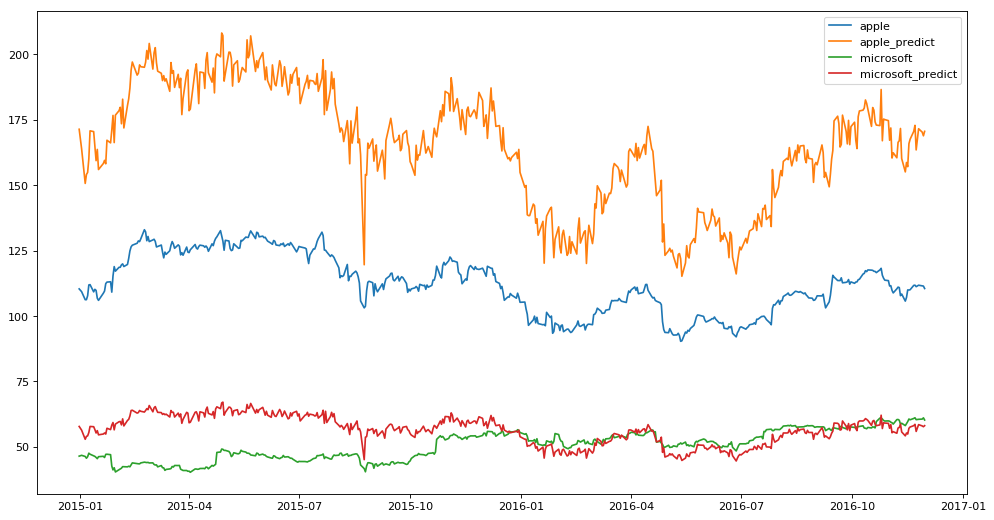

In [17]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = micro['Date'][0], end = micro['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

# plt.plot(index[:2033] ,train_y, label='micro')
# plt.plot(index[:2033] ,predict_train, label='micro')
plt.plot(index[2033:] ,np.squeeze(test_y[:,1:],axis=1), label='apple')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,1:],axis=1),1), label='apple_predict')

plt.plot(index[2033:] ,np.squeeze(test_y[:,:1],axis=1), label='microsoft')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,:1],axis=1),1), label='microsoft_predict')
# plt.plot(index ,micro['compound'], label='compound')

plt.legend()
_ = plt.ylim()

In [21]:
a_score=(abs(np.squeeze(test_y[:,1:],axis=1)-np.squeeze(predict[:,1:],axis=1))/np.squeeze(test_y[:,1:],axis=1)).sum()
a_score

224.84934748027814

In [19]:
m_score=(abs(np.squeeze(test_y[:,:1],axis=1)-np.squeeze(predict[:,:1],axis=1))/np.squeeze(test_y[:,:1],axis=1)).sum()
m_score

85.64775101931673

## Refined model

In [40]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(300,activation='relu' ))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# layer 5
model.add(Dense(150,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(2))

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 128)            73216     
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
__________

#### Compile the model

In [42]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/combine_simple training_'+str(time), write_graph=True)

model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

filepath="Weights/combine_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

In [43]:
model.fit(
        train_x
        ,train_y
        , epochs=80
        ,batch_size=50
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/80
1829/1829 [==============================] - 5s 3ms/step - loss: 1599.4838 - acc: 0.6277 - val_loss: 5615.3671 - val_acc: 0.0000e+00
Epoch 2/80
1829/1829 [==============================] - 1s 495us/step - loss: 1518.5347 - acc: 0.7633 - val_loss: 5618.8500 - val_acc: 0.0000e+00
Epoch 3/80
1829/1829 [==============================] - 1s 488us/step - loss: 1464.4804 - acc: 0.8311 - val_loss: 5631.3043 - val_acc: 0.0000e+00
Epoch 4/80
1829/1829 [==============================] - 1s 539us/step - loss: 1424.3699 - acc: 0.8387 - val_loss: 5550.7884 - val_acc: 0.7157
Epoch 5/80
1829/1829 [==============================] - 1s 528us/step - loss: 1388.5102 - acc: 0.8447 - val_loss: 5234.3286 - val_acc: 1.0000
Epoch 6/80
1829/1829 [==============================] - 1s 508us/step - loss: 1357.7814 - acc: 0.8540 - val_loss: 5398.6373 - val_acc: 1.0000
Epoch 7/80
1829/1829 [==============================] - 1s 501us/step - loss: 1323.4782 - a

Epoch 27/80
1829/1829 [==============================] - 2s 831us/step - loss: 532.1130 - acc: 0.9180 - val_loss: 584.2593 - val_acc: 1.0000
Epoch 28/80
1829/1829 [==============================] - 2s 843us/step - loss: 494.9190 - acc: 0.9103 - val_loss: 482.3428 - val_acc: 1.0000
Epoch 29/80
1829/1829 [==============================] - 2s 876us/step - loss: 452.2387 - acc: 0.9191 - val_loss: 460.6891 - val_acc: 1.0000
Epoch 30/80
1829/1829 [==============================] - 1s 671us/step - loss: 414.8390 - acc: 0.9136 - val_loss: 340.7937 - val_acc: 1.0000
Epoch 31/80
1829/1829 [==============================] - 1s 632us/step - loss: 375.5885 - acc: 0.9158 - val_loss: 398.6545 - val_acc: 1.0000
Epoch 32/80
1829/1829 [==============================] - 1s 736us/step - loss: 333.6575 - acc: 0.9202 - val_loss: 355.8041 - val_acc: 1.0000
Epoch 33/80
1829/1829 [==============================] - 1s 719us/step - loss: 296.5998 - acc: 0.9251 - val_loss: 348.6602 - val_acc: 1.0000
Epoch 34/80
1

1829/1829 [==============================] - 1s 499us/step - loss: 28.0148 - acc: 0.9213 - val_loss: 43.0471 - val_acc: 1.0000
Epoch 56/80
1829/1829 [==============================] - 1s 483us/step - loss: 31.4054 - acc: 0.9109 - val_loss: 99.2792 - val_acc: 1.0000
Epoch 57/80
1829/1829 [==============================] - 1s 503us/step - loss: 27.3217 - acc: 0.9202 - val_loss: 124.6856 - val_acc: 1.0000
Epoch 58/80
1829/1829 [==============================] - 1s 577us/step - loss: 26.0635 - acc: 0.9174 - val_loss: 67.0771 - val_acc: 1.0000
Epoch 59/80
1829/1829 [==============================] - 1s 739us/step - loss: 26.7110 - acc: 0.9076 - val_loss: 23.7968 - val_acc: 1.0000
Epoch 60/80
1829/1829 [==============================] - 1s 762us/step - loss: 26.8951 - acc: 0.9076 - val_loss: 66.3550 - val_acc: 1.0000
Epoch 61/80
1829/1829 [==============================] - 2s 849us/step - loss: 29.1590 - acc: 0.9032 - val_loss: 55.5611 - val_acc: 1.0000
Epoch 62/80
1829/1829 [===============

In [44]:
predict=model.predict(test_x)

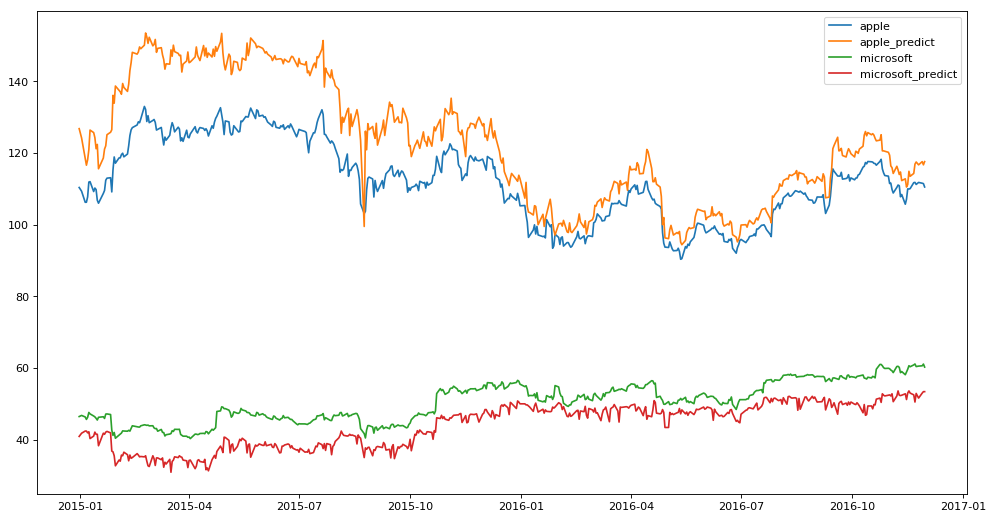

In [45]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = micro['Date'][0], end = micro['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

# plt.plot(index[:2033] ,train_y, label='micro')
# plt.plot(index[:2033] ,predict_train, label='micro')
plt.plot(index[2033:] ,np.squeeze(test_y[:,1:],axis=1), label='apple')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,1:],axis=1),1), label='apple_predict')

plt.plot(index[2033:] ,np.squeeze(test_y[:,:1],axis=1), label='microsoft')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,:1],axis=1),1), label='microsoft_predict')
# plt.plot(index ,micro['compound'], label='compound')

plt.legend()
_ = plt.ylim()

##### Score of model on Apple data

In [46]:
(abs(np.squeeze(test_y[:,1:],axis=1)-np.squeeze(predict[:,1:],axis=1))/np.squeeze(test_y[:,1:],axis=1)).sum()

43.907763266038216

##### Score of model on Apple data

In [47]:
(abs(np.squeeze(test_y[:,:1],axis=1)-np.squeeze(predict[:,:1],axis=1))/np.squeeze(test_y[:,:1],axis=1)).sum()

62.12926864634808

During the training the model got overfit on the treaning data as the training loos kept on decreasing and the validataion loss increased significantly and the last weights of the model donot have a good score.

Hence I used the following code to load the check point weights on the model

In [48]:
# dave the current weights
model.save('combo.old.hdf5')
# load the chekcpoint
from keras.models import load_model
model=load_model('combine_weights.best.hdf5')
predict=model.predict(test_x)

to load the last weights if the checkpoint weight gives even worse results

In [36]:
model=load_model('combo.old.hdf5')

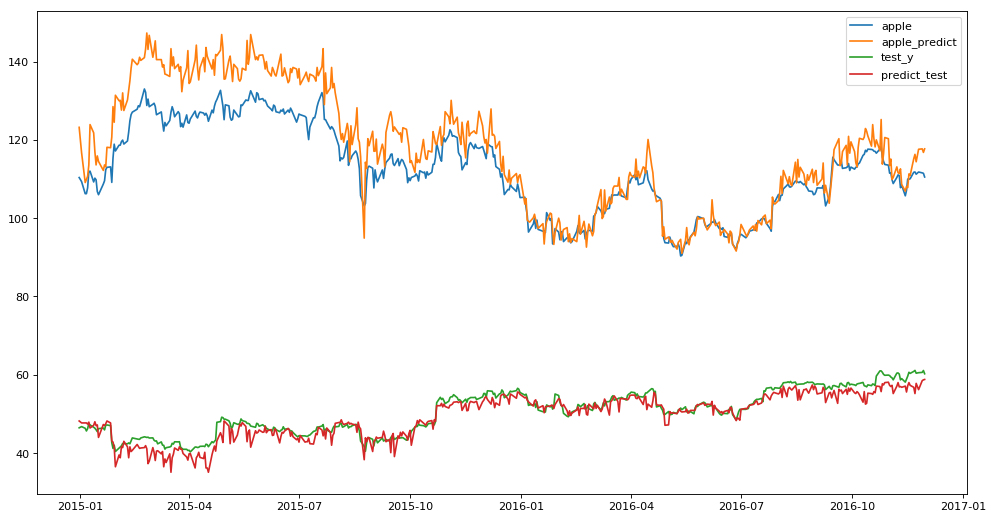

In [49]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = micro['Date'][0], end = micro['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[2033:] ,np.squeeze(test_y[:,1:],axis=1), label='apple')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,1:],axis=1),1), label='apple_predict')

plt.plot(index[2033:] ,np.squeeze(test_y[:,:1],axis=1), label='test_y')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,:1],axis=1),1), label='predict_test')

_ = plt.ylim()

##### Score of model on Apple data on chekpoint weights

In [50]:
(abs(np.squeeze(test_y[:,1:],axis=1)-np.squeeze(predict[:,1:],axis=1))/np.squeeze(test_y[:,1:],axis=1)).sum()

22.731907406635415

##### Score of model on Microsoft data on checkpoint weights

In [51]:
(abs(np.squeeze(test_y[:,:1],axis=1)-np.squeeze(predict[:,:1],axis=1))/np.squeeze(test_y[:,:1],axis=1)).sum()

15.058720469092883

## Framed Learning

compile the model

In [71]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

#  for the training log of tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/combine_framed_'+str(time), write_graph=True)
# to save the checkpoints of the model
filepath="Weights/combine_weights_framed.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

#### Train the model

In [72]:
l=len(train_x)
frame=int(l*0.40)
shift=int(l*.1)
start=0
brake=False
end_frame=False
step=0
while brake==False:
    if start+frame<l:
        step+=1
        print(step,'  :::::::::::::::::::::::::::::::::::::::::::::')
        X=train_x[start:start+frame]
        Y=train_y[start:start+frame]
        model.fit(
                    X
                    ,Y
                    , epochs=30
                    ,batch_size=50

                    ,verbose=1
                    ,validation_split=0.1 
                    ,callbacks=callbacks_list
                    )
        start=start+shift
    
    else:
        
        if end_frame==True:
            step+=1
            print(step,start,'end train  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=20
                        ,batch_size=50

                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            brake=True
        else:
            step+=1
            print(step,start,'end frame  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=30
                        ,batch_size=50

                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            start=start+shift
            end_frame=True
            

1   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 5s 6ms/step - loss: 1885.5816 - acc: 0.0492 - val_loss: 534.6826 - val_acc: 0.1341
Epoch 2/30
731/731 [==============================] - 1s 945us/step - loss: 1799.8239 - acc: 0.0492 - val_loss: 746.3063 - val_acc: 0.1341
Epoch 3/30
731/731 [==============================] - 0s 679us/step - loss: 1734.2830 - acc: 0.0492 - val_loss: 956.7535 - val_acc: 0.1341
Epoch 4/30
731/731 [==============================] - 1s 1ms/step - loss: 1673.2965 - acc: 0.0492 - val_loss: 1012.2098 - val_acc: 0.1341
Epoch 5/30
731/731 [==============================] - 1s 1ms/step - loss: 1615.2050 - acc: 0.0492 - val_loss: 1005.9723 - val_acc: 0.1341
Epoch 6/30
731/731 [==============================] - 1s 769us/step - loss: 1559.3195 - acc: 0.0492 - val_loss: 998.5180 - val_acc: 0.1341
Epoch 7/30
731/731 [==============================] - 1s 709us/step - loss:

Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 444.1527 - acc: 0.2298 - val_loss: 242.4101 - val_acc: 1.0000
Epoch 2/30
731/731 [==============================] - 1s 1ms/step - loss: 421.3653 - acc: 0.2298 - val_loss: 237.8895 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 1s 693us/step - loss: 399.7147 - acc: 0.2298 - val_loss: 268.1693 - val_acc: 1.0000
Epoch 4/30
731/731 [==============================] - 1s 688us/step - loss: 379.4462 - acc: 0.2298 - val_loss: 257.8353 - val_acc: 1.0000
Epoch 5/30
731/731 [==============================] - 1s 859us/step - loss: 358.9397 - acc: 0.2298 - val_loss: 235.3934 - val_acc: 1.0000
Epoch 6/30
731/731 [==============================] - 1s 747us/step - loss: 339.3543 - acc: 0.2298 - val_loss: 212.7311 - val_acc: 1.0000
Epoch 7/30
731/731 [==============================] - 1s 719us/step - loss: 320.7263 - acc: 0.2298 - val_loss: 179.8531 - val_acc: 1.0000
Epoch 8/30
731/731 [==================

Epoch 27/30
731/731 [==============================] - 1s 912us/step - loss: 73.9279 - acc: 0.2339 - val_loss: 26.3889 - val_acc: 1.0000
Epoch 28/30
731/731 [==============================] - 1s 1ms/step - loss: 66.0525 - acc: 0.2394 - val_loss: 25.3194 - val_acc: 1.0000
Epoch 29/30
731/731 [==============================] - 1s 773us/step - loss: 59.7074 - acc: 0.2490 - val_loss: 23.5495 - val_acc: 1.0000
Epoch 30/30
731/731 [==============================] - 1s 736us/step - loss: 53.5249 - acc: 0.2503 - val_loss: 20.6084 - val_acc: 1.0000
3   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 1s 858us/step - loss: 20.5909 - acc: 0.5554 - val_loss: 10.5862 - val_acc: 1.0000
Epoch 2/30
731/731 [==============================] - 0s 587us/step - loss: 16.9212 - acc: 0.5513 - val_loss: 17.6253 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 1s 724us/step - loss: 12.9087 - a

731/731 [==============================] - 1s 1ms/step - loss: 5.4107 - acc: 0.8550 - val_loss: 5.6850 - val_acc: 1.0000
Epoch 28/30
731/731 [==============================] - 0s 659us/step - loss: 6.2184 - acc: 0.8755 - val_loss: 7.4514 - val_acc: 1.0000
Epoch 29/30
731/731 [==============================] - 0s 582us/step - loss: 5.3855 - acc: 0.8659 - val_loss: 6.3413 - val_acc: 1.0000
Epoch 30/30
731/731 [==============================] - 1s 846us/step - loss: 4.4964 - acc: 0.8605 - val_loss: 7.1242 - val_acc: 1.0000
4   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 1s 945us/step - loss: 80.7122 - acc: 0.8304 - val_loss: 55.5292 - val_acc: 1.0000
Epoch 2/30
731/731 [==============================] - 0s 666us/step - loss: 70.2191 - acc: 0.8413 - val_loss: 123.6416 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 1s 757us/step - loss: 65.0808 - acc: 0.8440 - val_lo

Epoch 29/30
731/731 [==============================] - 1s 1ms/step - loss: 7.7122 - acc: 0.8769 - val_loss: 85.9852 - val_acc: 1.0000
Epoch 30/30
731/731 [==============================] - 1s 1ms/step - loss: 7.3794 - acc: 0.8933 - val_loss: 72.2112 - val_acc: 1.0000
5   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 152.9474 - acc: 0.9152 - val_loss: 3.4500 - val_acc: 1.0000
Epoch 2/30
731/731 [==============================] - 0s 649us/step - loss: 137.7857 - acc: 0.9193 - val_loss: 6.3035 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 0s 641us/step - loss: 123.3932 - acc: 0.9207 - val_loss: 14.1689 - val_acc: 1.0000
Epoch 4/30
731/731 [==============================] - 1s 714us/step - loss: 111.4525 - acc: 0.9275 - val_loss: 13.7622 - val_acc: 1.0000
Epoch 5/30
731/731 [==============================] - 1s 909us/step - loss: 102.8711 - acc: 0

Epoch 30/30
731/731 [==============================] - 1s 869us/step - loss: 10.9880 - acc: 0.9850 - val_loss: 3.8587 - val_acc: 1.0000
6   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 1s 853us/step - loss: 45.9647 - acc: 0.9973 - val_loss: 13.3244 - val_acc: 1.0000
Epoch 2/30
731/731 [==============================] - 1s 686us/step - loss: 35.0444 - acc: 0.9986 - val_loss: 26.2045 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 1s 1ms/step - loss: 29.3720 - acc: 0.9959 - val_loss: 20.3584 - val_acc: 1.0000
Epoch 4/30
731/731 [==============================] - 1s 1ms/step - loss: 23.5394 - acc: 1.0000 - val_loss: 19.3273 - val_acc: 1.0000
Epoch 5/30
731/731 [==============================] - 1s 1ms/step - loss: 19.0097 - acc: 1.0000 - val_loss: 17.0691 - val_acc: 1.0000
Epoch 6/30
731/731 [==============================] - 1s 1ms/step - loss: 17.6862 - acc: 1.0000

Epoch 2/30
731/731 [==============================] - 0s 623us/step - loss: 42.0374 - acc: 1.0000 - val_loss: 81.4431 - val_acc: 1.0000
Epoch 3/30
731/731 [==============================] - 1s 796us/step - loss: 33.8714 - acc: 1.0000 - val_loss: 64.7912 - val_acc: 1.0000
Epoch 4/30
731/731 [==============================] - 1s 920us/step - loss: 26.9674 - acc: 1.0000 - val_loss: 52.7483 - val_acc: 1.0000
Epoch 5/30
731/731 [==============================] - 1s 1ms/step - loss: 22.0656 - acc: 1.0000 - val_loss: 33.9095 - val_acc: 1.0000
Epoch 6/30
731/731 [==============================] - 1s 901us/step - loss: 17.3152 - acc: 1.0000 - val_loss: 31.2583 - val_acc: 1.0000
Epoch 7/30
731/731 [==============================] - 1s 1ms/step - loss: 14.5515 - acc: 1.0000 - val_loss: 17.3911 - val_acc: 1.0000
Epoch 8/30
731/731 [==============================] - 1s 935us/step - loss: 11.3553 - acc: 1.0000 - val_loss: 16.2571 - val_acc: 1.0000
Epoch 9/30
731/731 [==============================] 

550/550 [==============================] - 0s 755us/step - loss: 8.1223 - acc: 1.0000 - val_loss: 3.9224 - val_acc: 1.0000
Epoch 4/30
550/550 [==============================] - 0s 742us/step - loss: 8.5722 - acc: 1.0000 - val_loss: 2.8668 - val_acc: 1.0000
Epoch 5/30
550/550 [==============================] - 0s 761us/step - loss: 7.2500 - acc: 1.0000 - val_loss: 6.5418 - val_acc: 1.0000
Epoch 6/30
550/550 [==============================] - 0s 665us/step - loss: 6.5874 - acc: 1.0000 - val_loss: 7.3070 - val_acc: 1.0000
Epoch 7/30
550/550 [==============================] - 0s 611us/step - loss: 6.6323 - acc: 1.0000 - val_loss: 6.2008 - val_acc: 1.0000
Epoch 8/30
550/550 [==============================] - 0s 698us/step - loss: 6.1403 - acc: 1.0000 - val_loss: 7.4595 - val_acc: 1.0000
Epoch 9/30
550/550 [==============================] - 0s 684us/step - loss: 7.2674 - acc: 1.0000 - val_loss: 9.9792 - val_acc: 1.0000
Epoch 10/30
550/550 [==============================] - 0s 678us/step - lo

Epoch 5/20
368/368 [==============================] - 0s 742us/step - loss: 10.7869 - acc: 1.0000 - val_loss: 8.4939 - val_acc: 1.0000
Epoch 6/20
368/368 [==============================] - 0s 706us/step - loss: 8.6710 - acc: 1.0000 - val_loss: 7.1814 - val_acc: 1.0000
Epoch 7/20
368/368 [==============================] - 0s 946us/step - loss: 7.9626 - acc: 1.0000 - val_loss: 6.9072 - val_acc: 1.0000
Epoch 8/20
368/368 [==============================] - 0s 799us/step - loss: 9.2765 - acc: 1.0000 - val_loss: 7.8150 - val_acc: 1.0000
Epoch 9/20
368/368 [==============================] - 0s 879us/step - loss: 7.2866 - acc: 1.0000 - val_loss: 7.4334 - val_acc: 1.0000
Epoch 10/20
368/368 [==============================] - 0s 770us/step - loss: 6.7982 - acc: 1.0000 - val_loss: 9.3894 - val_acc: 1.0000
Epoch 11/20
368/368 [==============================] - 0s 744us/step - loss: 6.5461 - acc: 1.0000 - val_loss: 9.2804 - val_acc: 1.0000
Epoch 12/20
368/368 [==============================] - 0s 8

#### test the model on testing data 

In [73]:
predict=model.predict(test_x)

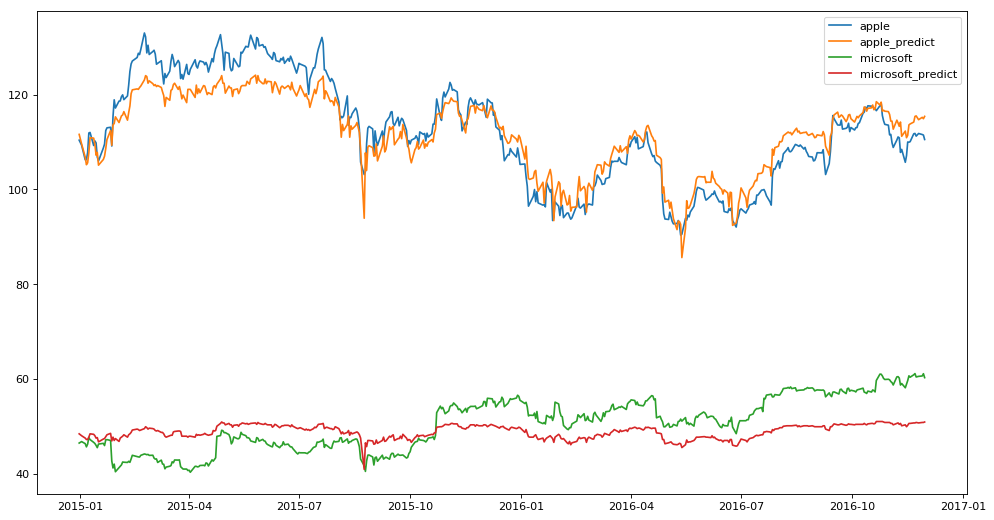

In [68]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = micro['Date'][0], end = micro['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

# plt.plot(index[:2033] ,train_y, label='micro')
# plt.plot(index[:2033] ,predict_train, label='micro')
plt.plot(index[2033:] ,np.squeeze(test_y[:,1:],axis=1), label='apple')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,1:],axis=1),1), label='apple_predict')

plt.plot(index[2033:] ,np.squeeze(test_y[:,:1],axis=1), label='microsoft')
plt.plot(index[2033:],np.round(np.squeeze(predict[:,:1],axis=1),1), label='microsoft_predict')
# plt.plot(index ,micro['compound'], label='compound')

plt.legend()
_ = plt.ylim()

##### Score of model on Apple data

In [69]:
(abs(np.squeeze(test_y[:,1:],axis=1)-np.squeeze(predict[:,1:],axis=1))/np.squeeze(test_y[:,1:],axis=1)).sum()

14.982973205048719

##### Score of model on Microsoft data

In [70]:
(abs(np.squeeze(test_y[:,:1],axis=1)-np.squeeze(predict[:,:1],axis=1))/np.squeeze(test_y[:,:1],axis=1)).sum()

46.47536830625038